In [112]:
import math
import numpy as np
from scipy import signal
import scipy
from matplotlib import pyplot as plt
import cv2 as cv

from matplotlib import cbook
from mpl_toolkits.axes_grid1.axes_rgb import RGBAxes, make_rgb_axes

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.axes_rgb import RGBAxes
from matplotlib import cbook
from PIL import Image

# Processing Functions

In [181]:
def change_brightness(image, amount):
    image = image.astype(np.int64)
    image = np.clip(image * amount, 0, 255)
    return image

def change_contrast(image, amount):
    bright = (image > 128) * amount * image
    low = (image <= 128) / amount * image
    return np.clip(bright+low, 0, 255)

def change_brightness_alt(image: np.ndarray, amount):
    """Change brightness of alternating pixels"""
    filter = np.ones(image.shape)
    filter[::2, ::2] = amount
    filter[1::2, 1::2] = amount
    return np.clip(image * filter, 0, 255)

def change_colorspace(image: cv.Mat | np.ndarray, space_in: str, space_out: str):
    match (space_in, space_out):
        case ("BGR", "RGB"):
            return cv.cvtColor(image, cv.COLOR_BGR2RGB)
        case ("RGB", "BGR"):
            return cv.cvtColor(image, cv.COLOR_RGB2BGR)
        case ("BGR", "HSV"):
            return cv.cvtColor(image, cv.COLOR_BGR2HSV)
        case ("HSV", "BGR"):
            return cv.cvtColor(image, cv.COLOR_HSV2BGR)
        case ("RGB", "HSV"):
            return cv.cvtColor(image, cv.COLOR_RGB2HSV)
        case ("HSV", "RGB"):
            return cv.cvtColor(image, cv.COLOR_HSV2RGB)
        case _:
            raise ValueError("Invalid colorspace")

def conv_identity(image: cv.Mat | np.ndarray, kernel_size: int):
    # Create Identity Kernel
    identity = np.zeros([kernel_size, kernel_size])
    identity[math.floor(kernel_size / 2), math.floor(kernel_size / 2)] = 1
    channels = cv.split(image)

    convolved_channels = [signal.convolve2d(channel, identity, boundary='symm', mode='same') for channel in channels]

    res = cv.merge(convolved_channels)

    return res

def conv_box(image: cv.Mat | np.ndarray, kernel_size):
    # Add code to convolve image with box filter here
     # Create Kernel
    box = np.ones([kernel_size, kernel_size])

    channels = cv.split(image)

    convolved_channels = [signal.convolve2d(channel, box, boundary='symm', mode='same') for channel in channels]

    res = cv.merge(convolved_channels)
    res /= kernel_size**2
    return res

def conv_sharpen(image, kernel_size):
    """Convolve image with sharpen filter"""
    # Create Kernel
    sharpen = np.ones([kernel_size, kernel_size]) * -1
    sharpen[math.floor(kernel_size/2), math.floor(kernel_size/2)] = kernel_size**2
    
    channels = cv.split(image)

    convolved_channels = [signal.convolve2d(channel, sharpen, boundary='symm', mode='same') for channel in channels]

    res = cv.merge(convolved_channels)
    return np.clip(res, 0, 255)

def gaussian_kernel(size, sigma):
    """Generates a (size x size) Gaussian kernel with a given sigma (variance)."""
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    
    kernel = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    return kernel / np.sum(kernel)  # Normalize the kernel

# Function to compute the kernel size based on sigma
def get_kernel_size(sigma):
    """Computes the kernel size based on sigma using 2 * π * sigma, rounded to the nearest odd integer."""
    kernel_size = int(round(2 * math.pi * sigma))
    if kernel_size % 2 == 0:
        kernel_size += 1  # Ensure the kernel size is odd
    return kernel_size

# Function to apply Gaussian blur to an RGB image
def conv_gaussian(image, sigma):
    """Applies Gaussian blur to a 3-channel image using a kernel based on the variance sigma."""
    kernel_size = get_kernel_size(sigma)
    kernel = gaussian_kernel(kernel_size, sigma)
    channels = cv.split(image)
    convolved_channels = [signal.convolve2d(channel, kernel, boundary='symm', mode='same') for channel in channels]
    res = cv.merge(convolved_channels)
    return np.clip(res, 0, 255)

def display_res(orig_one, orig_two, new_one, new_two, operation):
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    
    ax[0, 0].imshow(orig_one.astype(np.uint8))
    ax[0, 0].set_title("Original Image One")
    ax[0, 1].imshow(orig_two.astype(np.uint8))
    ax[0, 1].set_title("Original Image Two")
    ax[1, 0].set_title(f"{operation} One")
    ax[1, 0].imshow(new_one.astype(np.uint8))
    ax[1, 1].set_title(f"{operation} Two")
    ax[1, 1].imshow(new_two.astype(np.uint8))
    plt.show()

def display_rgb(image):
    _, ax = plt.subplot_mosaic(
            [["image", "R"], ["G", "B"]], figsize=(15, 10)
        )
    red = image[:,:,0]
    ax["image"].imshow(image.astype(np.uint8))
    ax["image"].set_title("Original Image")
    ax["R"].imshow(red.astype(np.uint8), cmap="Reds")
    ax["R"].set_title("R Channel")
    ax["G"].set_title("G Channel")
    ax["G"].imshow(image[:, :, 1].astype(np.uint8), cmap="Greens")
    ax["B"].set_title("B Channel")
    ax["B"].imshow(image[:, :, 2].astype(np.uint8), cmap="Blues")
    plt.show()

from mpl_toolkits.axes_grid1.axes_rgb import RGBAxes
from PIL import Image

def get_rgb(image_path):
    # Load image
    image = Image.open(image_path)
    image = image.convert('RGB')  # Ensure it's in RGB format
    image_array = np.array(image) / 255.0  # Normalize to [0, 1] range
    
    # Extract R, G, B channels
    R = image_array[:, :, 0]
    G = image_array[:, :, 1]
    B = image_array[:, :, 2]

    return R, G, B

def make_cube(r, g, b):
    ny, nx = r.shape
    R = np.zeros((ny, nx, 3))
    R[:, :, 0] = r
    G = np.zeros_like(R)
    G[:, :, 1] = g
    B = np.zeros_like(R)
    B[:, :, 2] = b

    RGB = R + G + B

    return R, G, B, RGB

def demo_rgb1(image_path):
    fig = plt.figure()
    ax = RGBAxes(fig, [0.1, 0.1, 0.8, 0.8], pad=0.0)
    
    # Get RGB from the provided image
    r, g, b = get_rgb(image_path)
    
    # Display the RGB image
    ax.imshow_rgb(r, g, b)
    plt.show()

def display_rgb_hist(image):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display the RGB image
    axs[0].imshow(image)
    axs[0].set_title('RGB Image')
    axs[0].axis('off')
    
    # Plot the histograms
    axs[1].hist(image[:, :, 0].flatten(), bins=256, color='red', alpha=0.5, label='Red')
    axs[1].hist(image[:, :, 1].flatten(), bins=256, color='green', alpha=0.5, label='Green')
    axs[1].hist(image[:, :, 2].flatten(), bins=256, color='blue', alpha=0.5, label='Blue')
    axs[1].set_title('Histogram')
    axs[1].legend()
    
    # Show the plot
    fig.show()

def get_hsv(image_path):
    # Load the image using OpenCV
    image = cv.imread(image_path)
    
    # Convert BGR (default in OpenCV) to HSV
    hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    
    # Extract H, S, V channels
    H = hsv_image[:, :, 0]  # Hue
    S = hsv_image[:, :, 1]  # Saturation
    V = hsv_image[:, :, 2]  # Value

    return H, S, V

def demo_hsv(image_path):
    # Get HSV from the provided image
    h, s, v = get_hsv(image_path)
    
    # Create a figure to display the three channels
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Normalize channels for display (Matplotlib requires normalization to [0, 1])
    h_normalized = h / 255.0
    s_normalized = s / 255.0
    v_normalized = v / 255.0
    
    # Display the channels
    axs[0].imshow(h_normalized, cmap='gray')
    axs[0].set_title('Hue')
    axs[0].axis('off')

    axs[1].imshow(s_normalized, cmap='gray')
    axs[1].set_title('Saturation')
    axs[1].axis('off')

    axs[2].imshow(v_normalized, cmap='gray')
    axs[2].set_title('Value')
    axs[2].axis('off')

    # Show the plot
    plt.show()


# Load Images

In [134]:
img_path = "assets/"
image_name_one = "IMAGE002.jpg"
image_name_two = "IMAGE000.jpg"
# Image (1)
image_gray_one = cv.imread(img_path + image_name_one, cv.IMREAD_GRAYSCALE)
image_color_one = cv.imread(img_path + image_name_one, cv.IMREAD_COLOR)
image_color_one = cv.cvtColor(image_color_one, cv.COLOR_BGR2RGB)

# Image (2)
image_gray_two = cv.imread(img_path + image_name_two, cv.IMREAD_GRAYSCALE)
image_color_two = cv.imread(img_path + image_name_two, cv.IMREAD_COLOR)
image_color_two = cv.cvtColor(image_color_two, cv.COLOR_BGR2RGB)
print(image_color_one.shape)

(480, 640, 3)


# Pixel Processing

## Brightness

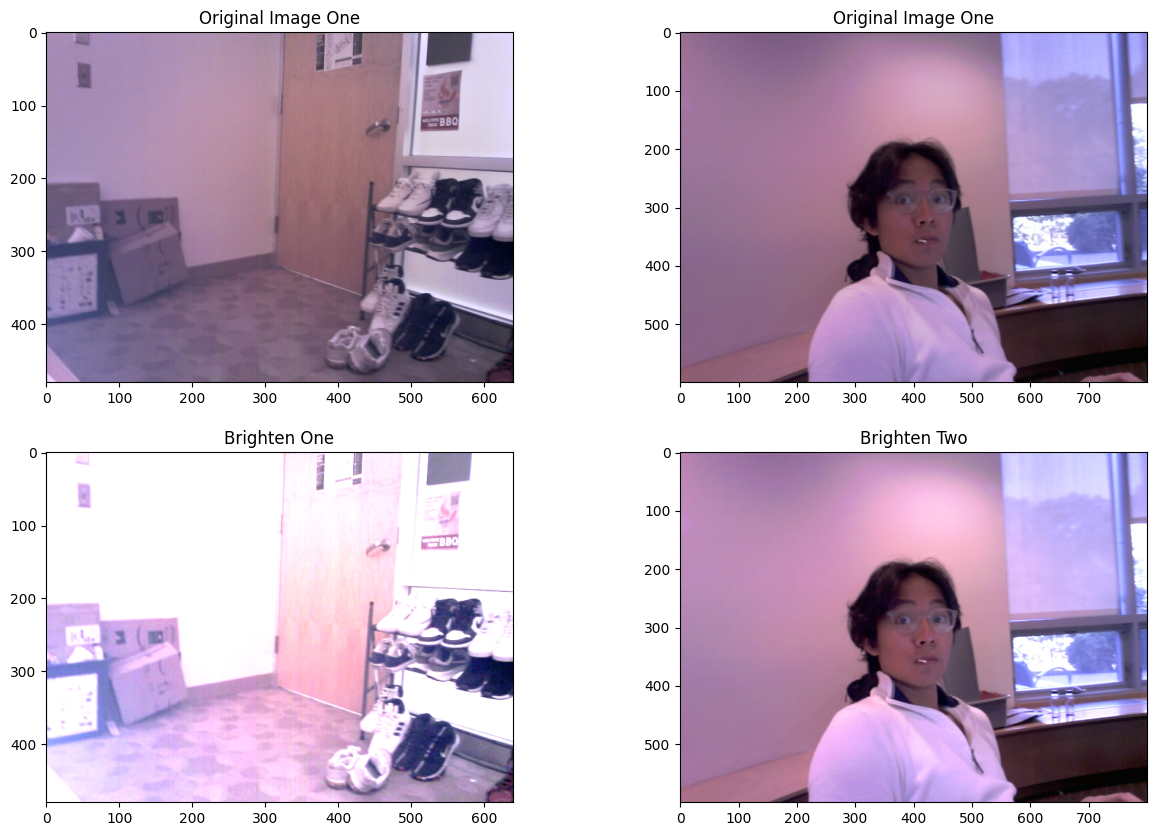

In [61]:
image_bright_one = change_brightness(image_color_one, 2)
image_bright_two = change_brightness(image_color_two, 1.2)

display_res(image_color_one, image_color_two,
    image_bright_one, image_bright_two, "Brighten")

## Contrast

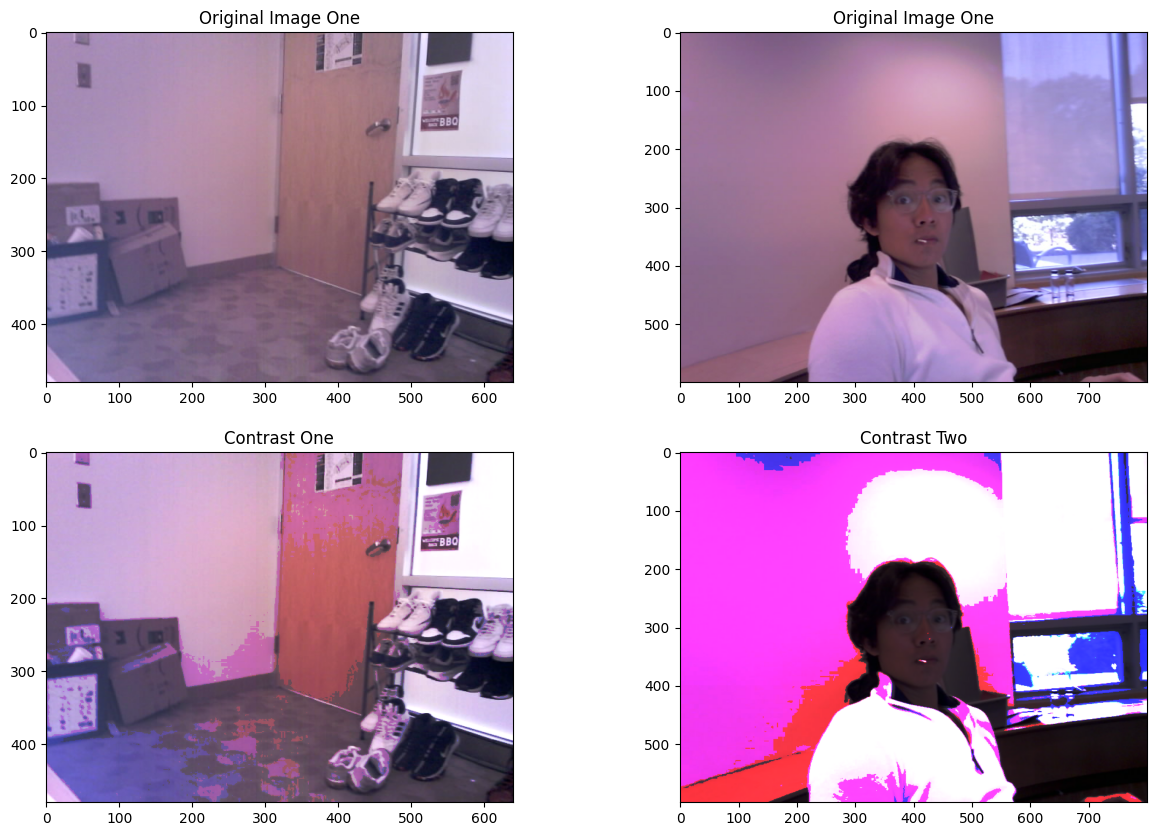

In [76]:
image_contrast_one = change_contrast(image_color_one, 1.2)
image_contrast_two = change_contrast(image_color_two, 1.8)

display_res(image_color_one, image_color_two,
    image_contrast_one, image_contrast_two, "Contrast")

## Alternating Pixel Brightness

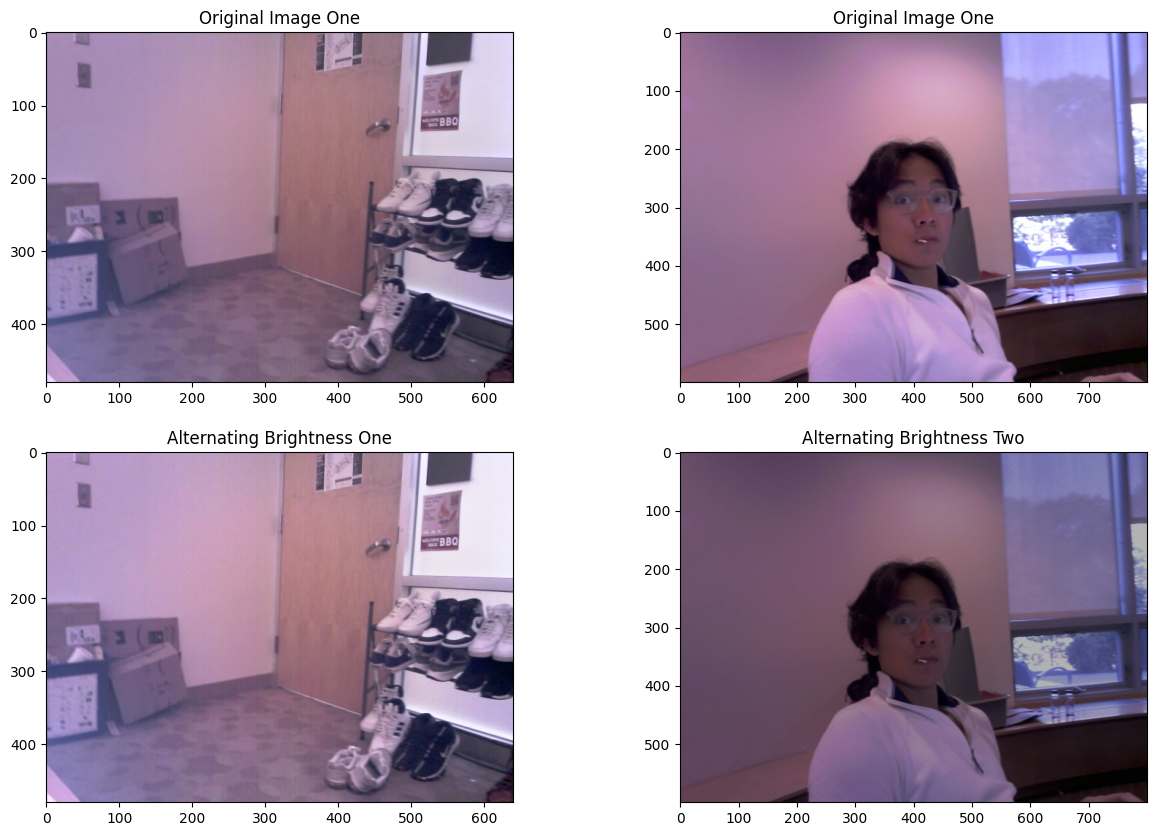

In [83]:
image_alt_one = change_brightness_alt(image_color_one, 1.2)
image_alt_two = change_brightness_alt(image_color_two, 0.4)

display_res(image_color_one, image_color_two,
    image_alt_one, image_alt_two, "Alternating Brightness")

# Color Spaces

## RGB Channels

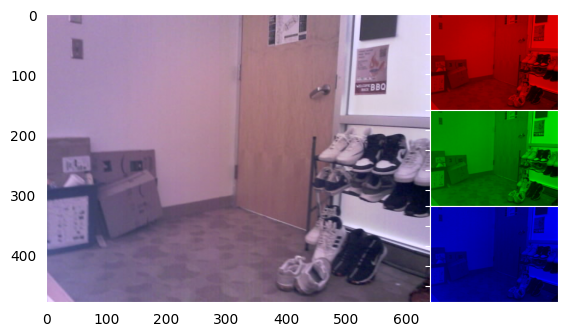

/tmp/ipykernel_11147/1393857465.py:183: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


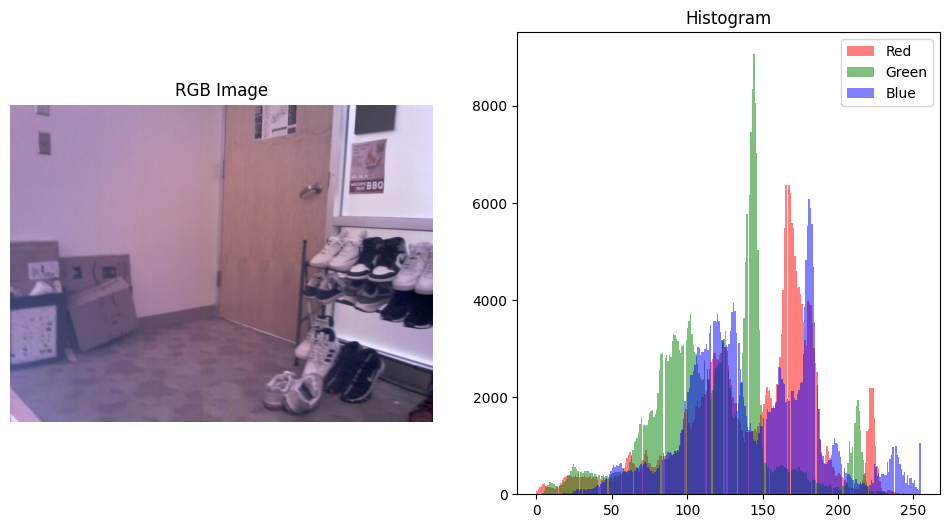

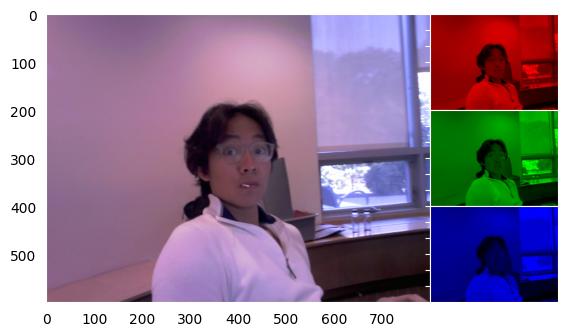

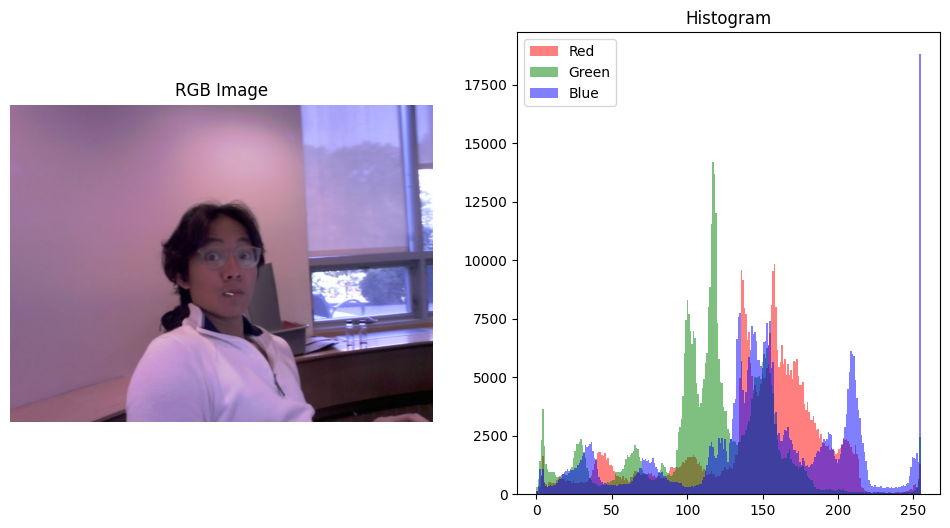

In [182]:
demo_rgb1(img_path + image_name_one)
display_rgb_hist(image_color_one)
demo_rgb1(img_path + image_name_two)
display_rgb_hist(image_color_two)

# Extract HSV Channels

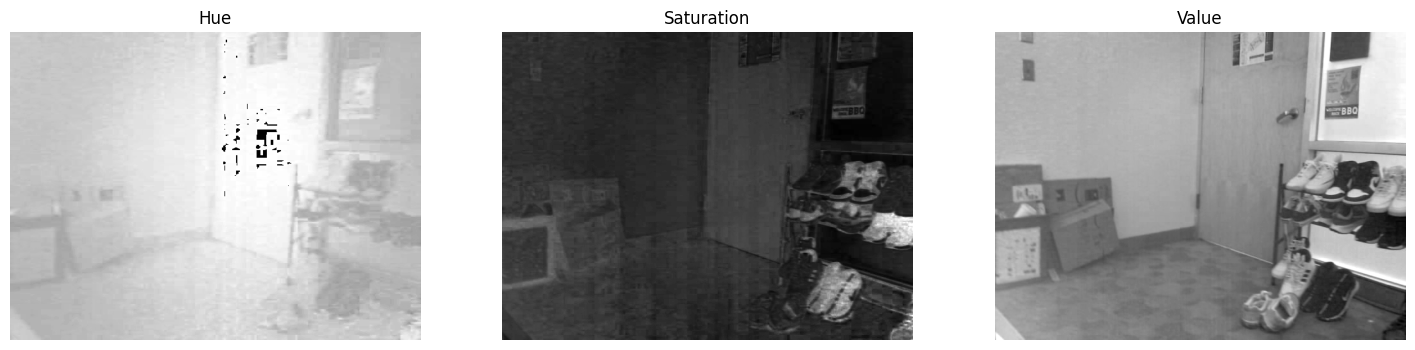

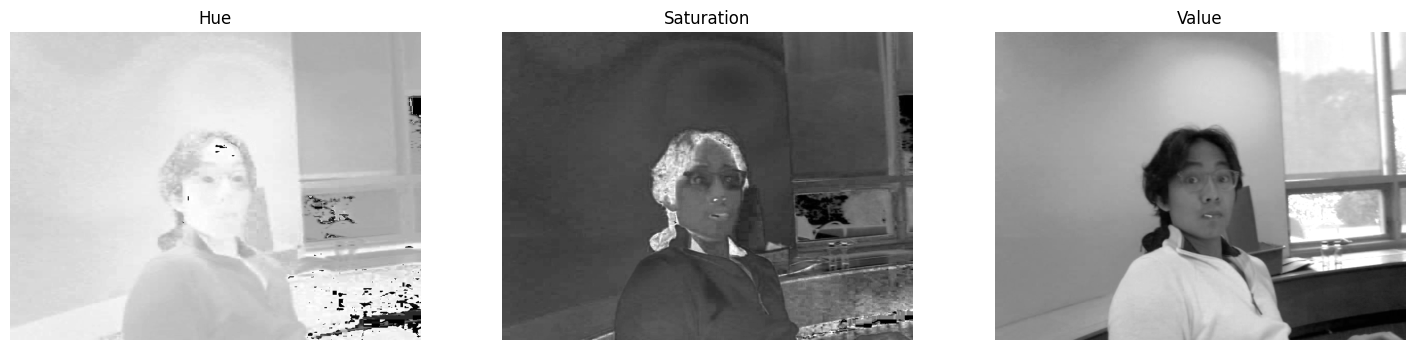

In [127]:
demo_hsv(img_path + image_name_one)
demo_hsv(img_path + image_name_two)

# Convolutions

## Identity Filter

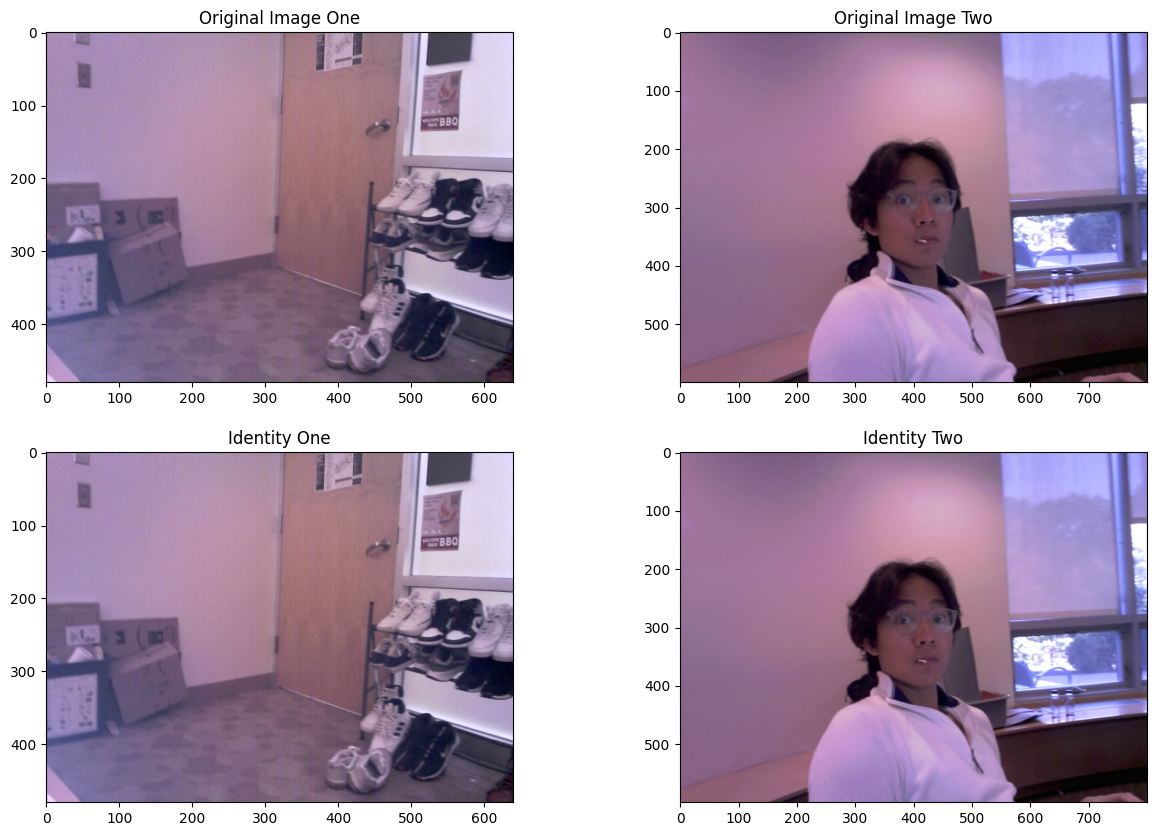

In [149]:
image_identity_one = conv_identity(image_color_one, 3)
image_identity_two = conv_identity(image_color_two, 3)
display_res(image_color_one, image_color_two, image_identity_one, image_identity_two, "Identity")

## Box Blur Filter

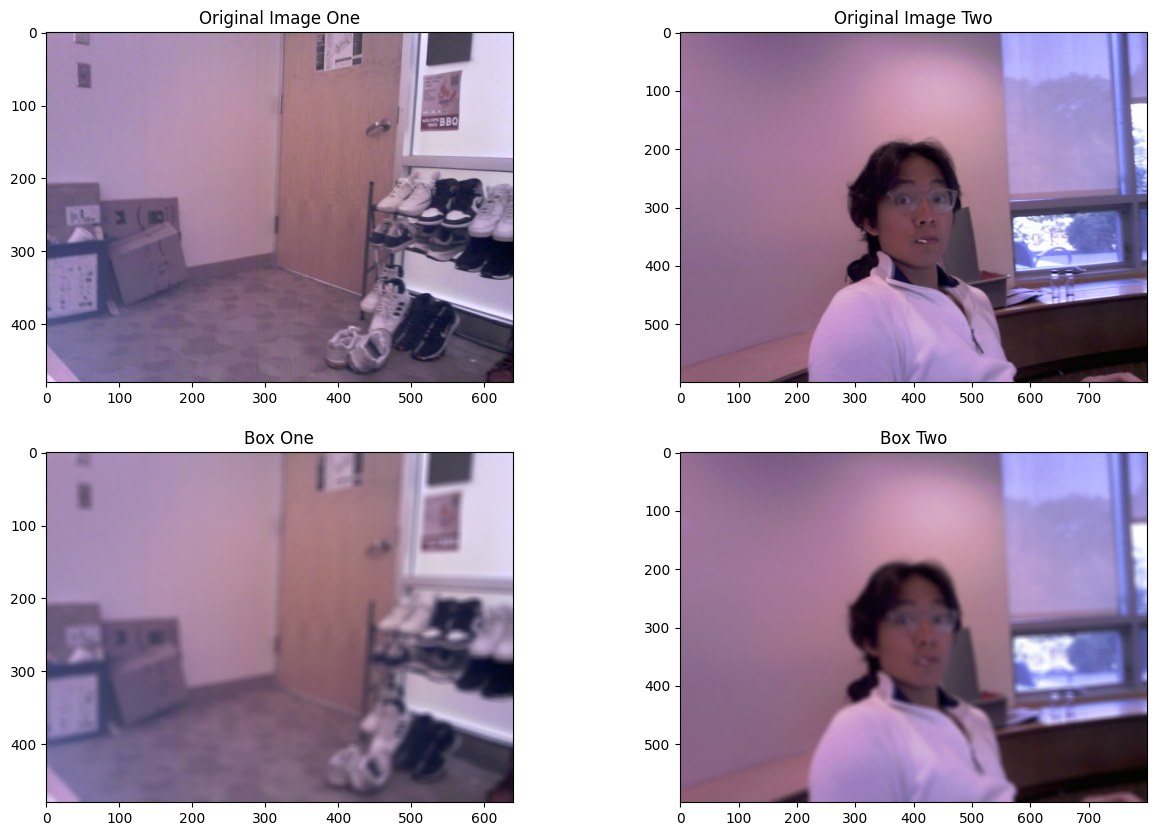

In [158]:
image_box_one = conv_box(image_color_one, 10)
image_box_two = conv_box(image_color_two, 10)
display_res(image_color_one, image_color_two, image_box_one, image_box_two, "Box")


## Sharpen Filter

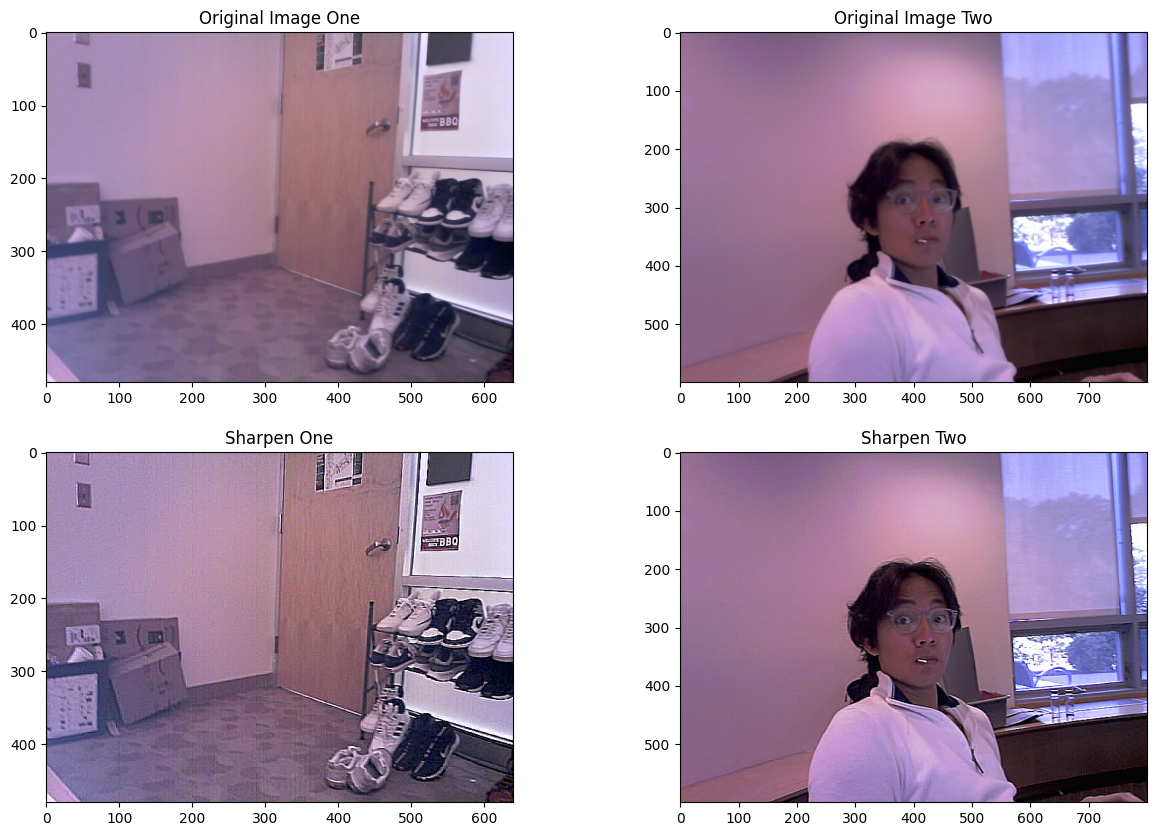

In [161]:
image_sharpen_one = conv_sharpen(image_color_one, 3)
image_sharpen_two = conv_sharpen(image_color_two, 3)
display_res(image_color_one, image_color_two, image_sharpen_one, image_sharpen_two, "Sharpen")

## Gaussian Blur Filter

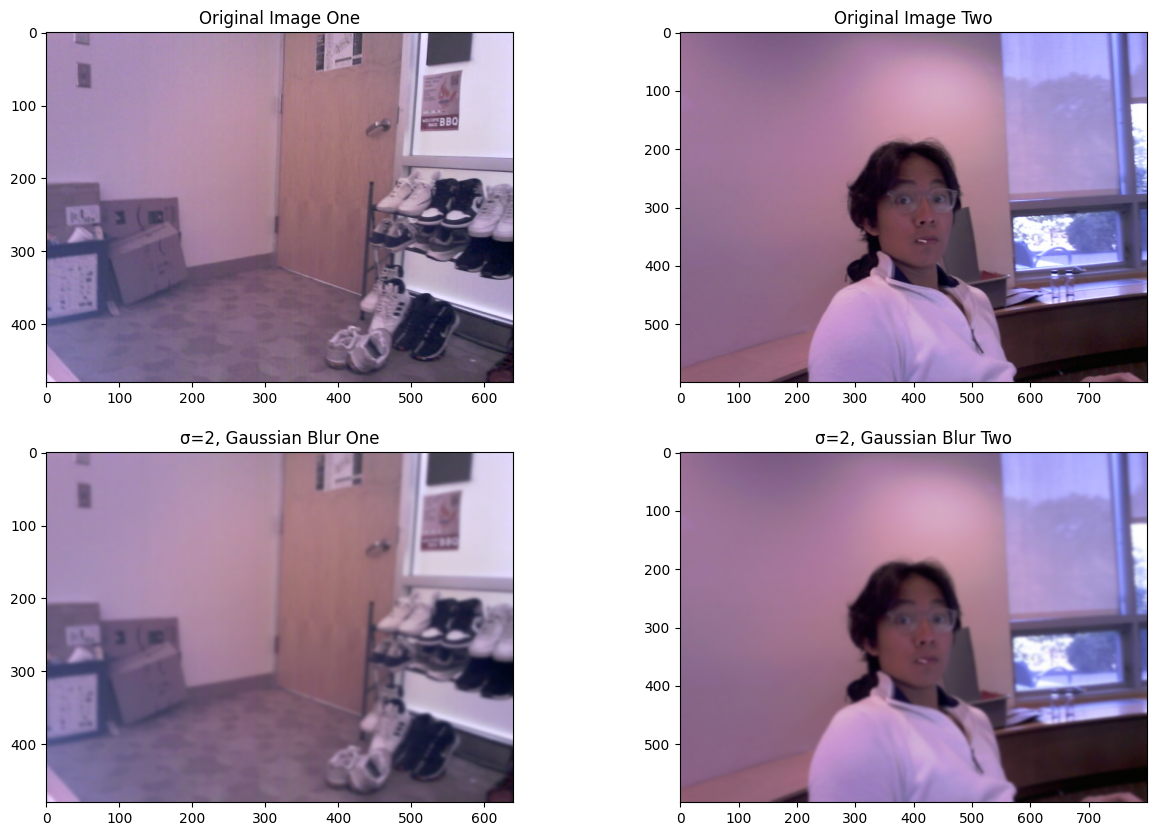

In [170]:
sigma = 2
image_gauss_one = conv_gaussian(image_color_one, sigma)
image_gauss_two = conv_gaussian(image_color_two, sigma)
display_res(image_color_one, image_color_two, image_gauss_one, image_gauss_two, f"σ={sigma}, Gaussian Blur")